# Figures 4-cell case

Code to reproduce Fig. 4(b) - 4(d)

# Import packages 

In [3]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
from matplotlib.pyplot import cm
from scipy.special import xlogy
#from mpl_toolkits.axes_grid1 import make_axes_locatable
#from scipy.ndimage import maximum_filter

# Model 

Equations describing the temporal evolution of $R_b$, $Q_b$ and $E^*$ (Eq.1-3 of the main text): 

$\dot{R}_b = k_{d\scriptscriptstyle+}c (R-R_b) - k_{d\scriptscriptstyle-} R_b+ \xi_{R} ;$ 

    
$\dot{Q}_b= k_{e\scriptscriptstyle+} e (Q-Q_b) - k_{e\scriptscriptstyle-} Q_b+ \xi_{Q} ; $ 


$ \dot{E}^* = V_s \frac{R_b^2}{R_b^2 + K_s^2}(E_T- E^*) - \left ( V_{rg}\frac{Q_b}{Q_b + K_{rg}} + k \right ) E^* + \xi_{E}$ 


Standard values of the parameters

In [7]:
# Normalized concentration of molecules c_v = [FGF]/[FGF]_0, e_v = [eph]/[eph]_0
c_v =  5  
e_v =  5 

# Total number of molecules in each cell
Rt_v =  2000 # Total number of FGF receptors
Qt_v =  2000 # Total number of ephrin receptors
Erkt_v= 4000 # Total number of ERK molecules

# Values of the reaction rates  
Kd =  60 # Normalised binding constant of FGF
kd_plus_v = 0.1  
kd_minus_v = Kd*kd_plus_v
 
Ke =  40 # Normalised binding constant of ephrin
ke_plus_v = 0.1 
ke_minus_v = Ke*ke_plus_v

k_v =  0.2 # ERK* de-activation constant
Vs_v=  1*k_v # Maximal rate of ERK activation (by Rb)
Vrg_v = 0.4*k_v # Maximal rate of ERK* deactivation (by Qb)

Ks_v =  200  # Half saturation constant for Rb
Krg_v =  200 # Half saturation constant for Qb

# Cell surface
Scell_v = 6000 # Total cell surface (um^2)
S1max = Scell_v/2 # Maximum surface exposed to FGF
S1_v = 0.5*Scell_v # Surface exposed to FGF (um^2)

# The surface exposed to FGF (S1) is related to the surface exposed to ephrin (S2) through Eq.5:
# S2 = A*S1+B*Scell  
A = -1.1265
B = 0.9092

Function to compute the number of active ERK molecules ($E^*$) (Eq. 1-3)

In [9]:
# Function to compute ERK as a function of the input 
def ERK(c, args):  
    
    kd_plus, kd_minus, ke_plus, ke_minus, S1, e, k, Ks, Krg, Vs, Vrg, Qt, Rt, Erkt, Scell = args

    S2= A*S1 +B*Scell
    Rb_ss = Rt*S1/Scell*c/(c+kd_minus/kd_plus)
    Qb_ss = Qt*S2/Scell*e/(e+ke_minus/ke_plus)
    Erk_ss = Erkt* (Vs*Rb_ss**2/(Rb_ss**2+Ks**2)) /(Vs*Rb_ss**2/(Rb_ss**2+Ks**2) + Vrg*Qb_ss/(Qb_ss+Krg)+ k)
        
    return np.float32(Erk_ss) 

Function to compute the noise in the number of active ERK molecules ($\sigma_e$) (Eq. 22 - 28)

In [11]:
# Function to compute the noise as a function of the input 
def sigma(c, args):
    
    kd_plus, kd_minus, ke_plus, ke_minus, S1, e, k, Ks, Krg, Vs, Vrg, Qt, Rt, Erkt, Scell = args

    S2= A*S1 +B*Scell
    Rb_ss = Rt*S1/Scell*c/(c+kd_minus/kd_plus)
    Qb_ss = Qt*S2/Scell*e/(e+ke_minus/ke_plus)
    Erk_ss = Erkt* (Vs*Rb_ss**2/(Rb_ss**2+Ks**2)) /(Vs*Rb_ss**2/(Rb_ss**2+Ks**2) + Vrg*Qb_ss/(Qb_ss+Krg)+ k)

    Tau_c = (kd_plus*c+kd_minus)**(-1)
    Tau_e = (ke_plus*e+ke_minus)**(-1)
    Tau_E = (k + Vs*Rb_ss**2/(Rb_ss**2+Ks**2) + Vrg*Qb_ss/(Qb_ss+Krg) )**(-1)

    Gamma_R = 2*Vs*Rb_ss*Ks**2/(Rb_ss**2+Ks**2)**2*(Erkt-Erk_ss)
    Gamma_Q = Vrg*Krg/(Qb_ss+Krg)**2*Erk_ss

    n_ss = c*kd_plus/(kd_minus + c*kd_plus)
    m_ss = e*ke_plus/(ke_minus + e*ke_plus)

    A_R = 2/Tau_c*Rt*S1/Scell*n_ss*(1-n_ss)
    A_Q = 2/Tau_e*Qt*S2/Scell*m_ss*(1-m_ss)
    A_E = 2*Vs*Rb_ss**2/(Rb_ss**2+Ks**2)*(Erkt-Erk_ss)

    sigma_R = Gamma_R**2*A_R/2*(Tau_c-Tau_E)/(Tau_E**(-2)-Tau_c**(-2))
    sigma_Q = Gamma_Q**2*A_Q/2*(Tau_e-Tau_E)/(Tau_E**(-2)-Tau_e**(-2))
    sigma_E = A_E/2*Tau_E

    sigma2 = sigma_R + sigma_Q + sigma_E
        
    return np.float32(np.sqrt(sigma2))

# Information transmission

Input probability distribution $P(c)$: lognormal distribution centered around $\mu_c$, with variance $\sigma_F^2$.

$P(c) = \frac{1}{c \sqrt{2\pi \sigma_F^2}} \exp{\left (-\frac{(\ln{(c)}-\mu_c)^2}{\sigma_F^2} \right )}$   (Eq. 7 of the main text)

In [14]:
# Lognormal distribution
def Pf_Lognorm(var, mu_c, sigma_F): 
    mu = np.log(mu_c**2/np.sqrt(mu_c**2+sigma_F**2))
    sig = np.sqrt(np.log(1+sigma_F**2/mu_c**2))
    distr = 1/(2*np.pi*sig**2*var**2)**(1/2)*np.exp(-1/2*((np.log(var)-mu)/sig)**2) 
    return distr

Function to compute the conditional probability distribution $P(E^*|c) = \mathcal{G}(E^*, \bar{E}^*, \sigma_e^2)$ (Eq. 9)

In [16]:
def P_ERKF(var, ERK_temp, args):
    
    # Gaussian centered around ERK_v, with std = sigma_v 
    ERK_v = ERK(var, args=args)
    sigma_v = sigma(var, args=args)

    distr = 1/(2*np.pi*sigma_v**2)**(1/2)*np.exp(-1/2*((ERK_temp - ERK_v)/sigma_v)**2)   
    
    # Return the normalized distribution    
    return distr/np.trapz(distr,ERK_temp)

Function to compute the output distribution $P(\{E_A^*, E_B^*, E_C^*, E_D^*\})$

In [18]:
def PERK_4c(ERK_A, ERK_B, ERK_C, ERK_D, c_temp, Pc, argsA, argsB, argsC, argsD):
    
    integral = np.zeros((len(ERK_A), len(ERK_B), len(ERK_C), len(ERK_D)))
    
    for i in range(1, len(c_temp)): 
        PerkfA_1 = np.float32(P_ERKF(c_temp[i], ERK_A, args=argsA))
        PerkfB_1 = np.float32(P_ERKF(c_temp[i], ERK_B, args=argsB))
        PerkfC_1 = np.float32(P_ERKF(c_temp[i], ERK_C, args=argsC))
        PerkfD_1 = np.float32(P_ERKF(c_temp[i], ERK_D, args=argsD))
        
        PerkfA_0 = np.float32(P_ERKF(c_temp[i-1], ERK_A, args=argsA))
        PerkfB_0 = np.float32(P_ERKF(c_temp[i-1], ERK_B, args=argsB))
        PerkfC_0 = np.float32(P_ERKF(c_temp[i-1], ERK_C, args=argsC))
        PerkfD_0 = np.float32(P_ERKF(c_temp[i-1], ERK_D, args=argsD))
            
        # Reshape the arrays to create a 4D matrix with entries P(EA\c)*P(EB\c)*P(EC\c)*P(ED\c)*P(c)
        PerkfA_1, PerkfB_1, PerkfC_1, PerkfD_1 = np.meshgrid(PerkfA_1, PerkfB_1, PerkfC_1, PerkfD_1, indexing='ij')
        PerkfA_0, PerkfB_0, PerkfC_0, PerkfD_0 = np.meshgrid(PerkfA_0, PerkfB_0, PerkfC_0, PerkfD_0, indexing='ij')
        
        integrand_1 = PerkfA_1*PerkfB_1*PerkfC_1*PerkfD_1*np.float32(Pc[i])
        integrand_0 = PerkfA_0*PerkfB_0*PerkfC_0*PerkfD_0*np.float32(Pc[i-1])
        
        del PerkfA_0, PerkfB_0, PerkfC_0, PerkfD_0, PerkfA_1, PerkfB_1, PerkfC_1, PerkfD_1
        
        delta_c = np.float32(c_temp[i]-c_temp[i-1])
        integral_step = (integrand_1+integrand_0)*delta_c/2
        
        del  integrand_1, integrand_0
        
        integral= integral + integral_step
    
    del integral_step
    
    # Return the output matrix
    return integral


Function to compute the entropy of $P(\{E_A^*, E_B^*, E_C^*, E_D^*\})$:

$ S[P(\{E_A^*, E_B^*, E_C^*, E_D^*\})] = - \int P(\{E_A^*, E_B^*, E_C^*, E_D^*\}) \log_2(P(\{E_A^*, E_B^*, E_C^*, E_D^*\})) dE_A^* dE_B^* dE_C^* dE_D^*$ 

In [20]:
def SPERK_4c(ERK_A, ERK_B, ERK_C, ERK_D, c_temp, Pc, argsA, argsB, argsC, argsD):
    
    distr = np.zeros((len(ERK_A), len(ERK_B), len(ERK_C), len(ERK_D)))
    
    for i in range(1, len(c_temp)): 
        PerkfA_1 = np.float32(P_ERKF(c_temp[i], ERK_A, args=argsA))
        PerkfB_1 = np.float32(P_ERKF(c_temp[i], ERK_B, args=argsB))
        PerkfC_1 = np.float32(P_ERKF(c_temp[i], ERK_C, args=argsC))
        PerkfD_1 = np.float32(P_ERKF(c_temp[i], ERK_D, args=argsD))
        
        PerkfA_0 = np.float32(P_ERKF(c_temp[i-1], ERK_A, args=argsA))
        PerkfB_0 = np.float32(P_ERKF(c_temp[i-1], ERK_B, args=argsB))
        PerkfC_0 = np.float32(P_ERKF(c_temp[i-1], ERK_C, args=argsC))
        PerkfD_0 = np.float32(P_ERKF(c_temp[i-1], ERK_D, args=argsD))
            
        # Reshape the arrays to create a 3D matrix with entries P(EA\c)*P(EB\c)*P(EC\c)*P(c)
        PerkfA_1, PerkfB_1, PerkfC_1, PerkfD_1 = np.meshgrid(PerkfA_1, PerkfB_1, PerkfC_1, PerkfD_1, indexing='ij')
        PerkfA_0, PerkfB_0, PerkfC_0, PerkfD_0 = np.meshgrid(PerkfA_0, PerkfB_0, PerkfC_0, PerkfD_0, indexing='ij')
        
        integrand_1 = PerkfA_1*PerkfB_1*PerkfC_1*PerkfD_1*np.float32(Pc[i])
        integrand_0 = PerkfA_0*PerkfB_0*PerkfC_0*PerkfD_0*np.float32(Pc[i-1])
        
        del PerkfA_0, PerkfB_0, PerkfC_0, PerkfD_0, PerkfA_1, PerkfB_1, PerkfC_1, PerkfD_1
        
        delta_c = np.float32(c_temp[i]-c_temp[i-1])
        integral_step = (integrand_1+integrand_0)*delta_c/2
        
        del  integrand_1, integrand_0
        
        distr = distr + integral_step

    del integral_step
    
    integral = - np.trapz(np.trapz(np.trapz(np.trapz(xlogy(distr, distr)/np.log(2), ERK_A, axis=0), ERK_B, axis=0), ERK_C, axis=0), ERK_D)

    del distr

    # Return the integral of the distribution
    return integral

Function to compute information:

$I(c;\{E_A^*, E_B^*, E_C^*, E_D^*\}) =- \int P(\{E_A^*, E_B^*, E_C^*, E_D^*\})\log_2(P(\{E_A^*, E_B^*, E_C^*, E_D^*\})) dE_A^* dE_B^* dE_C^* dE_D^* + $

$ \hspace{5.9 cm} + \int dc P(c) \int P(\{E_A^*, E_B^*, E_C^*, E_D^*\}|c)\log_2(P(\{E_A^*, E_B^*, E_C^*, E_D^*\}|c)) dE_A^* dE_B^* dE_C^* dE_D^* \quad $ (Eq. 30 with N=4)


$ \hspace{4.5 cm} = S[P(\{E_A^*, E_B^*, E_C^*, E_D^*\})] + \int dc P(c) \Big [ \int P(E_A^*|c)\log_2(P(E_A^*|c)) dE_A^*  + \int P(E_B^*|c)\log_2(P(E_B^*|c)) dE_B^* + $

$ \hspace{5.9 cm} + \int P(E_C^*|c)\log_2(P(E_C^*|c)) dE_C^*  +  \int P(E_D^*|c)\log_2(P(E_D^*|c)) dE_D^* \Big ]$ 

$ \hspace{4.5 cm} = S[P(\{E_A^*, E_B^*, E_C^*, E_D^*\})] - \int dc P(c) \Big [ \log_2\left (\sqrt{2\pi e}\sigma_A(c) \right) +  \log_2 \left (\sqrt{2\pi e}\sigma_B(c) \right) + \log_2 \left (\sqrt{2\pi e}\sigma_C(c) \right)  + \log_2 \left (\sqrt{2\pi e}\sigma_D(c) \right) \Big ]$ 

In [22]:
def I_4c(c_temp, Pin, SPout, argsA, argsB, argsC, argsD):
    
    sigma_A = np.float32(sigma(c_temp, args = argsA))
    sigma_B = np.float32(sigma(c_temp, args = argsB))
    sigma_C = np.float32(sigma(c_temp, args = argsC))
    sigma_D = np.float32(sigma(c_temp, args = argsD))

    I2= - np.log2((2*np.pi*np.exp(1))**(4/2)*sigma_A*sigma_B*sigma_C*sigma_D)

    # Compute int P(c)*I2 dc 
    I3 = np.trapz(I2*Pin, c_temp)
    
    # Return information
    return  SPout + I3

# Figures

## Fig. 4(b) and 4(c)

Upload the data obatined with 'Computation_4cells.ipynb' . 

To reproduce the figures without running the code 'Computation_4cells.ipynb', use the data saved in 'Results_Info_4cells.zip'. 

In [42]:
S1tot_temp = np.loadtxt('S1tot_temp.txt')

Info_4cells = np.loadtxt('Info_4cells.txt')

S1A_4c = np.loadtxt('S1A_4c.txt')
S1B_4c = np.loadtxt('S1B_4c.txt')
S1C_4c = np.loadtxt('S1C_4c.txt')
S1D_4c = np.loadtxt('S1D_4c.txt')

# Reshape the arrays to have 3D matrices 
dim = int(np.round(len(Info_4cells[0])**(1/3),2))
Info_4cells_mat = [Info_4cells[i].reshape((dim, dim, dim)) for i in range(len(Info_4cells))]
S1A_S1t = [S1A_4c[i].reshape((dim, dim, dim)) for i in range(len(S1A_4c))]
S1B_S1t = [S1B_4c[i].reshape((dim, dim, dim)) for i in range(len(S1B_4c))]
S1C_S1t = [S1C_4c[i].reshape((dim, dim, dim)) for i in range(len(S1C_4c))]
S1D_S1t = [S1D_4c[i].reshape((dim, dim, dim)) for i in range(len(S1D_4c))]

Compute the values of $S_1^A, S_1^B, S_1^C, S_1^D$ for which information is maximal and $I^*$

In [28]:
# Compute {S1A*, S1B*, S1C*, S1D*} and I*
maxI = []
S1A_peaks = []
S1B_peaks = []
S1C_peaks = []
S1D_peaks = []

for i in range(len(Info_4cells_mat)): 
    info = np.round(Info_4cells_mat[i],6)
    
    I_peak = np.nanmax(info)
    
    S1A_peaks.append(S1A_S1t[i][info==I_peak])
    S1B_peaks.append(S1B_S1t[i][info==I_peak])
    S1C_peaks.append(S1C_S1t[i][info==I_peak])
    S1D_peaks.append(S1D_S1t[i][info==I_peak])
    maxI.append(I_peak)
    
    
# Rearrange the vectors for the plot 
S1A_peaks_plot = []
S1B_peaks_plot = []
S1C_peaks_plot = []
S1D_peaks_plot = []
S1t_plot = []

for i in range(len(S1tot_temp)): 
    for j in range(len(S1A_peaks[i])):
        S1A_peaks_plot.append(S1A_peaks[i][j])
        S1B_peaks_plot.append(S1B_peaks[i][j])
        S1C_peaks_plot.append(S1C_peaks[i][j])
        S1D_peaks_plot.append(S1D_peaks[i][j])
        S1t_plot.append(S1tot_temp[i])
        

Compute the information $I_{avg}$ transmitted if the 4 cells have the same surface exposed to FGF: $S_1^A=S_1^B=S_1^C= S_1^D=S_1^{tot}/4$

! All the parameter values must be equal to the ones used in Computation_4cells.ipynb ! 

In [30]:
# Total cell surfaces
ScellA_v = 6000
ScellB_v = 6000
ScellC_v = 6000 
ScellD_v = 6000

# Compute the input distribution
mu_c = 40
sigma_F= 1

cmin = np.max((mu_c-5*sigma_F, 1e-2))
cmax = mu_c+5*sigma_F
c_temp = np.linspace(cmin, cmax, 50)
P_in =  Pf_Lognorm(c_temp, sigma_F=sigma_F, mu_c=mu_c)

In [31]:
avgI_S1t = []

for k in range( len(S1tot_temp)):
    print(k)
    
    # Check that S1tot_temp/4 is lower than the maxS1 for the 4 cells: 
    if S1tot_temp[k]/4 > np.min((ScellA_v/2, ScellB_v/2, ScellC_v/2, ScellD_v/2 )): 
        avgI_S1t.append(np.NaN)
    else:
        argA = [kd_plus_v, kd_minus_v, ke_plus_v, ke_minus_v, S1tot_temp[k]/4, e_v, k_v, Ks_v, Krg_v, Vs_v, Vrg_v, Qt_v,\
               Rt_v, Erkt_v, ScellA_v]
        argB = [kd_plus_v, kd_minus_v, ke_plus_v, ke_minus_v, S1tot_temp[k]/4, e_v, k_v, Ks_v, Krg_v, Vs_v, Vrg_v, Qt_v,\
               Rt_v, Erkt_v, ScellB_v]
        argC = [kd_plus_v, kd_minus_v, ke_plus_v, ke_minus_v, S1tot_temp[k]/4, e_v, k_v, Ks_v, Krg_v, Vs_v, Vrg_v, Qt_v,\
               Rt_v, Erkt_v, ScellC_v]
        argD = [kd_plus_v, kd_minus_v, ke_plus_v, ke_minus_v, S1tot_temp[k]/4, e_v, k_v, Ks_v, Krg_v, Vs_v, Vrg_v, Qt_v,\
               Rt_v, Erkt_v, ScellD_v]

        ERKmaxA = ERK(cmax, args=argA)
        ERKmaxB = ERK(cmax, args=argB)
        ERKmaxC = ERK(cmax, args=argC)
        ERKmaxD = ERK(cmax, args=argD)

        ERKminA = ERK(cmin, args=argA)
        ERKminB = ERK(cmin, args=argB)
        ERKminC = ERK(cmin, args=argC)
        ERKminD = ERK(cmin, args=argD)

        ERK_tempA = np.linspace(np.max((ERKminA-ERKminA/4, 1e-4)), ERKmaxA+ ERKmaxA/4, 50, dtype=np.float32)
        ERK_tempB = np.linspace(np.max((ERKminB-ERKminB/4, 1e-4)), ERKmaxB+ ERKmaxB/4, 50, dtype=np.float32)
        ERK_tempC = np.linspace(np.max((ERKminC-ERKminC/4, 1e-4)), ERKmaxC+ ERKmaxC/4, 50, dtype=np.float32)
        ERK_tempD = np.linspace(np.max((ERKminD-ERKminD/4, 1e-4)), ERKmaxD+ ERKmaxD/4, 50, dtype=np.float32)

        SPout = SPERK_4c(ERK_tempA, ERK_tempB, ERK_tempC, ERK_tempD, \
                c_temp, P_in, argsA=argA, argsB=argB, argsC=argC, argsD=argD) 

        avgI_S1t_temp_4c = I_4c(c_temp, Pin=P_in, SPout= SPout, argsA=argA, argsB=argB, argsC= argC, argsD= argD)

        avgI_S1t.append(avgI_S1t_temp_4c)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


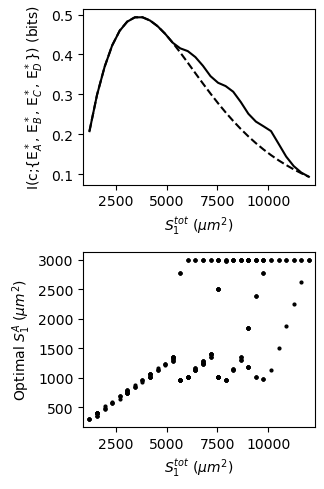

In [32]:
# Figure

plt.figure(figsize=(3.5,5))

# Plot I* and Iavg as a function of S1tot  
plt.subplot(211)
plt.plot(S1tot_temp, avgI_S1t, '--', color='black', label='I if the 4 cells \nhave the same S1')
plt.plot(S1tot_temp, maxI, '-', color='black', label='Maximal I')

plt.xlabel('$S_1^{tot}$ $(\\mu m^2)$' , fontsize=10)
plt.ylabel('I(c;{E$^*_A$, E$^*_B$, E$^*_C$, E$^*_D$}) (bits)', fontsize=10)
plt.xlim([S1tot_temp[0]-300, S1tot_temp[-1]+300])

# Plot the position of the peaks
plt.subplot(212)
plt.plot(S1t_plot, np.array(S1A_peaks_plot), '.',markersize=4, label=f'cell A (Scell = {ScellA_v})', color='k')
plt.plot(S1t_plot, np.array(S1B_peaks_plot), '.',markersize=4, label=f'cell B (Scell = {ScellB_v})', color='k')
plt.plot(S1t_plot, np.array(S1C_peaks_plot), '.',markersize=4, label=f'cell C (Scell = {ScellC_v})', color='k')
plt.plot(S1t_plot, np.array(S1D_peaks_plot), '.',markersize=4, label=f'cell D (Scell = {ScellD_v})', color='k')

plt.xlabel('$S_1^{tot}$ $(\\mu m^2)$', fontsize=10)
plt.ylabel('Optimal $S_{1}^A$ $(\\mu m^2)$', fontsize=10)
plt.xlim([S1tot_temp[0]-300, S1tot_temp[-1]+300])

plt.tight_layout()
plt.show()

## Fig. 4(d) and 4(e) 

Upload experimental data 

In [35]:
Stot_cellA_exp = np.loadtxt('a6.5_TotSurface.txt')
Stot_cellB_exp = np.loadtxt('a6.6_TotSurface.txt')
Stot_cellC_exp = np.loadtxt('a6.7_TotSurface.txt')
Stot_cellD_exp = np.loadtxt('a6.8_TotSurface.txt')

S1tot_exp = np.loadtxt('S1tot_exp.txt')

S1_cellA_exp = np.loadtxt('a6.5_S1.txt')
S1_cellB_exp = np.loadtxt('a6.6_S1.txt')
S1_cellC_exp = np.loadtxt('a6.7_S1.txt')
S1_cellD_exp = np.loadtxt('a6.8_S1.txt')


Upload data obtained with 'Computation_mu_scan.ipynb' . 

'Computation_mu_scan.ipynb' computes - for a single embryo (for example embryo # 1) - the max transmitted information (Info_embryo1) for increasing values of $\mu_c$ (cv_embryo1) and the corresponding optimal surfaces (S1opt_cellA_embryo1, S1opt_cellB_embryo1, S1opt_cellC_embryo1, S1opt_cellD_embryo1). 

To reproduce the figures without running 'Computation_mu_scan.ipynb' for each embryo, use the data saved in 'Results_mu_scan_perEmbryo.zip'. 

We do not compute the optimal values for ebryos #18 and #19 since in these embryos $S_{cell}^{6.5} > S_{cell}^{6.7}$. 

In [37]:
# Embryo 0 
Info_embryo0 = np.loadtxt('Imax_embryo0.txt')
cv_embryo0 = np.loadtxt('cv_temp_embryo0.txt')
S1opt_cellA_embryo0 = np.loadtxt('Opt_S1A_embryo0.txt')/Stot_cellA_exp[0]
S1opt_cellB_embryo0 = np.loadtxt('Opt_S1B_embryo0.txt')/Stot_cellB_exp[0]
S1opt_cellC_embryo0 = np.loadtxt('Opt_S1C_embryo0.txt')/Stot_cellC_exp[0]
S1opt_cellD_embryo0 = np.loadtxt('Opt_S1D_embryo0.txt')/Stot_cellD_exp[0]

# Embryo 1 
Info_embryo1 = np.loadtxt('Imax_embryo1.txt')
cv_embryo1 = np.loadtxt('cv_temp_embryo1.txt')
S1opt_cellA_embryo1 = np.loadtxt('Opt_S1A_embryo1.txt')/Stot_cellA_exp[1]
S1opt_cellB_embryo1 = np.loadtxt('Opt_S1B_embryo1.txt')/Stot_cellB_exp[1]
S1opt_cellC_embryo1 = np.loadtxt('Opt_S1C_embryo1.txt')/Stot_cellC_exp[1]
S1opt_cellD_embryo1 = np.loadtxt('Opt_S1D_embryo1.txt')/Stot_cellD_exp[1]

# Embryo 2 
Info_embryo2 = np.loadtxt('Imax_embryo2.txt')
cv_embryo2 = np.loadtxt('cv_temp_embryo2.txt')
S1opt_cellA_embryo2 = np.loadtxt('Opt_S1A_embryo2.txt')/Stot_cellA_exp[2]
S1opt_cellB_embryo2 = np.loadtxt('Opt_S1B_embryo2.txt')/Stot_cellB_exp[2]
S1opt_cellC_embryo2 = np.loadtxt('Opt_S1C_embryo2.txt')/Stot_cellC_exp[2]
S1opt_cellD_embryo2 = np.loadtxt('Opt_S1D_embryo2.txt')/Stot_cellD_exp[2]


# Embryo 4 
Info_embryo4 = np.loadtxt('Imax_embryo4.txt')
cv_embryo4 = np.loadtxt('cv_temp_embryo4.txt')
S1opt_cellA_embryo4 = np.loadtxt('Opt_S1A_embryo4.txt')/Stot_cellA_exp[4]
S1opt_cellB_embryo4 = np.loadtxt('Opt_S1B_embryo4.txt')/Stot_cellB_exp[4]
S1opt_cellC_embryo4 = np.loadtxt('Opt_S1C_embryo4.txt')/Stot_cellC_exp[4]
S1opt_cellD_embryo4 = np.loadtxt('Opt_S1D_embryo4.txt')/Stot_cellD_exp[4]

# Embryo 5 
Info_embryo5 = np.loadtxt('Imax_embryo5.txt')
cv_embryo5 = np.loadtxt('cv_temp_embryo5.txt')
S1opt_cellA_embryo5 = np.loadtxt('Opt_S1A_embryo5.txt')/Stot_cellA_exp[5]
S1opt_cellB_embryo5 = np.loadtxt('Opt_S1B_embryo5.txt')/Stot_cellB_exp[5]
S1opt_cellC_embryo5 = np.loadtxt('Opt_S1C_embryo5.txt')/Stot_cellC_exp[5]
S1opt_cellD_embryo5 = np.loadtxt('Opt_S1D_embryo5.txt')/Stot_cellD_exp[5]

# Embryo 6 
Info_embryo6 = np.loadtxt('Imax_embryo6.txt')
cv_embryo6 = np.loadtxt('cv_temp_embryo6.txt')
S1opt_cellA_embryo6 = np.loadtxt('Opt_S1A_embryo6.txt')/Stot_cellA_exp[6]
S1opt_cellB_embryo6 = np.loadtxt('Opt_S1B_embryo6.txt')/Stot_cellB_exp[6]
S1opt_cellC_embryo6 = np.loadtxt('Opt_S1C_embryo6.txt')/Stot_cellC_exp[6]
S1opt_cellD_embryo6 = np.loadtxt('Opt_S1D_embryo6.txt')/Stot_cellD_exp[6]

# Embryo 7 
Info_embryo7 = np.loadtxt('Imax_embryo7.txt')
cv_embryo7 = np.loadtxt('cv_temp_embryo7.txt')
S1opt_cellA_embryo7 = np.loadtxt('Opt_S1A_embryo7.txt')/Stot_cellA_exp[7]
S1opt_cellB_embryo7 = np.loadtxt('Opt_S1B_embryo7.txt')/Stot_cellB_exp[7]
S1opt_cellC_embryo7 = np.loadtxt('Opt_S1C_embryo7.txt')/Stot_cellC_exp[7]
S1opt_cellD_embryo7 = np.loadtxt('Opt_S1D_embryo7.txt')/Stot_cellD_exp[7]

# Embryo 8 
Info_embryo8 = np.loadtxt('Imax_embryo8.txt')
cv_embryo8 = np.loadtxt('cv_temp_embryo8.txt')
S1opt_cellA_embryo8 = np.loadtxt('Opt_S1A_embryo8.txt')/Stot_cellA_exp[8]
S1opt_cellB_embryo8 = np.loadtxt('Opt_S1B_embryo8.txt')/Stot_cellB_exp[8]
S1opt_cellC_embryo8 = np.loadtxt('Opt_S1C_embryo8.txt')/Stot_cellC_exp[8]
S1opt_cellD_embryo8 = np.loadtxt('Opt_S1D_embryo8.txt')/Stot_cellD_exp[8]

# Embryo 9 
Info_embryo9 = np.loadtxt('Imax_embryo9.txt')
cv_embryo9 = np.loadtxt('cv_temp_embryo9.txt')
S1opt_cellA_embryo9 = np.loadtxt('Opt_S1A_embryo9.txt')/Stot_cellA_exp[9]
S1opt_cellB_embryo9 = np.loadtxt('Opt_S1B_embryo9.txt')/Stot_cellB_exp[9]
S1opt_cellC_embryo9 = np.loadtxt('Opt_S1C_embryo9.txt')/Stot_cellC_exp[9]
S1opt_cellD_embryo9 = np.loadtxt('Opt_S1D_embryo9.txt')/Stot_cellD_exp[9]

# Embryo 10 
Info_embryo10 = np.loadtxt('Imax_embryo10.txt')
cv_embryo10 = np.loadtxt('cv_temp_embryo10.txt')
S1opt_cellA_embryo10 = np.loadtxt('Opt_S1A_embryo10.txt')/Stot_cellA_exp[10]
S1opt_cellB_embryo10 = np.loadtxt('Opt_S1B_embryo10.txt')/Stot_cellB_exp[10]
S1opt_cellC_embryo10 = np.loadtxt('Opt_S1C_embryo10.txt')/Stot_cellC_exp[10]
S1opt_cellD_embryo10 = np.loadtxt('Opt_S1D_embryo10.txt')/Stot_cellD_exp[10]

# Embryo 11 
Info_embryo11 = np.loadtxt('Imax_embryo11.txt')
cv_embryo11 = np.loadtxt('cv_temp_embryo11.txt')
S1opt_cellA_embryo11 = np.loadtxt('Opt_S1A_embryo11.txt')/Stot_cellA_exp[11]
S1opt_cellB_embryo11 = np.loadtxt('Opt_S1B_embryo11.txt')/Stot_cellB_exp[11]
S1opt_cellC_embryo11 = np.loadtxt('Opt_S1C_embryo11.txt')/Stot_cellC_exp[11]
S1opt_cellD_embryo11 = np.loadtxt('Opt_S1D_embryo11.txt')/Stot_cellD_exp[11]

# Embryo 12 
Info_embryo12 = np.loadtxt('Imax_embryo12.txt')
cv_embryo12 = np.loadtxt('cv_temp_embryo12.txt')
S1opt_cellA_embryo12 = np.loadtxt('Opt_S1A_embryo12.txt')/Stot_cellA_exp[12]
S1opt_cellB_embryo12 = np.loadtxt('Opt_S1B_embryo12.txt')/Stot_cellB_exp[12]
S1opt_cellC_embryo12 = np.loadtxt('Opt_S1C_embryo12.txt')/Stot_cellC_exp[12]
S1opt_cellD_embryo12 = np.loadtxt('Opt_S1D_embryo12.txt')/Stot_cellD_exp[12]

# Embryo 14 
Info_embryo14 = np.loadtxt('Imax_embryo14.txt')
cv_embryo14 = np.loadtxt('cv_temp_embryo14.txt')
S1opt_cellA_embryo14 = np.loadtxt('Opt_S1A_embryo14.txt')/Stot_cellA_exp[14]
S1opt_cellB_embryo14 = np.loadtxt('Opt_S1B_embryo14.txt')/Stot_cellB_exp[14]
S1opt_cellC_embryo14 = np.loadtxt('Opt_S1C_embryo14.txt')/Stot_cellC_exp[14]
S1opt_cellD_embryo14 = np.loadtxt('Opt_S1D_embryo14.txt')/Stot_cellD_exp[14]

# Embryo 15 
Info_embryo15 = np.loadtxt('Imax_embryo15.txt')
cv_embryo15 = np.loadtxt('cv_temp_embryo15.txt')
S1opt_cellA_embryo15 = np.loadtxt('Opt_S1A_embryo15.txt')/Stot_cellA_exp[15]
S1opt_cellB_embryo15 = np.loadtxt('Opt_S1B_embryo15.txt')/Stot_cellB_exp[15]
S1opt_cellC_embryo15 = np.loadtxt('Opt_S1C_embryo15.txt')/Stot_cellC_exp[15]
S1opt_cellD_embryo15 = np.loadtxt('Opt_S1D_embryo15.txt')/Stot_cellD_exp[15]

# Embryo 16 
Info_embryo16 = np.loadtxt('Imax_embryo16.txt')
cv_embryo16 = np.loadtxt('cv_temp_embryo16.txt')
S1opt_cellA_embryo16 = np.loadtxt('Opt_S1A_embryo16.txt')/Stot_cellA_exp[16]
S1opt_cellB_embryo16 = np.loadtxt('Opt_S1B_embryo16.txt')/Stot_cellB_exp[16]
S1opt_cellC_embryo16 = np.loadtxt('Opt_S1C_embryo16.txt')/Stot_cellC_exp[16]
S1opt_cellD_embryo16 = np.loadtxt('Opt_S1D_embryo16.txt')/Stot_cellD_exp[16]

# Embryo 17 
Info_embryo17 = np.loadtxt('Imax_embryo17.txt')
cv_embryo17 = np.loadtxt('cv_temp_embryo17.txt')
S1opt_cellA_embryo17 = np.loadtxt('Opt_S1A_embryo17.txt')/Stot_cellA_exp[17]
S1opt_cellB_embryo17 = np.loadtxt('Opt_S1B_embryo17.txt')/Stot_cellB_exp[17]
S1opt_cellC_embryo17 = np.loadtxt('Opt_S1C_embryo17.txt')/Stot_cellC_exp[17]
S1opt_cellD_embryo17 = np.loadtxt('Opt_S1D_embryo17.txt')/Stot_cellD_exp[17]

# Embryo 20 
Info_embryo20 = np.loadtxt('Imax_embryo20.txt')
cv_embryo20 = np.loadtxt('cv_temp_embryo20.txt')
S1opt_cellA_embryo20 = np.loadtxt('Opt_S1A_embryo20.txt')/Stot_cellA_exp[20]
S1opt_cellB_embryo20 = np.loadtxt('Opt_S1B_embryo20.txt')/Stot_cellB_exp[20]
S1opt_cellC_embryo20 = np.loadtxt('Opt_S1C_embryo20.txt')/Stot_cellC_exp[20]
S1opt_cellD_embryo20 = np.loadtxt('Opt_S1D_embryo20.txt')/Stot_cellD_exp[20]

# Embryo 21 
Info_embryo21 = np.loadtxt('Imax_embryo21.txt')
cv_embryo21 = np.loadtxt('cv_temp_embryo21.txt')
S1opt_cellA_embryo21 = np.loadtxt('Opt_S1A_embryo21.txt')/Stot_cellA_exp[21]
S1opt_cellB_embryo21 = np.loadtxt('Opt_S1B_embryo21.txt')/Stot_cellB_exp[21]
S1opt_cellC_embryo21 = np.loadtxt('Opt_S1C_embryo21.txt')/Stot_cellC_exp[21]
S1opt_cellD_embryo21 = np.loadtxt('Opt_S1D_embryo21.txt')/Stot_cellD_exp[21]

# Embryo 22 
Info_embryo22 = np.loadtxt('Imax_embryo22.txt')
cv_embryo22 = np.loadtxt('cv_temp_embryo22.txt')
S1opt_cellA_embryo22 = np.loadtxt('Opt_S1A_embryo22.txt')/Stot_cellA_exp[22]
S1opt_cellB_embryo22 = np.loadtxt('Opt_S1B_embryo22.txt')/Stot_cellB_exp[22]
S1opt_cellC_embryo22 = np.loadtxt('Opt_S1C_embryo22.txt')/Stot_cellC_exp[22]
S1opt_cellD_embryo22 = np.loadtxt('Opt_S1D_embryo22.txt')/Stot_cellD_exp[22]

# Embryo 23 
Info_embryo23 = np.loadtxt('Imax_embryo23.txt')
cv_embryo23 = np.loadtxt('cv_temp_embryo23.txt')
S1opt_cellA_embryo23 = np.loadtxt('Opt_S1A_embryo23.txt')/Stot_cellA_exp[23]
S1opt_cellB_embryo23 = np.loadtxt('Opt_S1B_embryo23.txt')/Stot_cellB_exp[23]
S1opt_cellC_embryo23 = np.loadtxt('Opt_S1C_embryo23.txt')/Stot_cellC_exp[23]
S1opt_cellD_embryo23 = np.loadtxt('Opt_S1D_embryo23.txt')/Stot_cellD_exp[23]

# Embryo 24 
Info_embryo24 = np.loadtxt('Imax_embryo24.txt')
cv_embryo24 = np.loadtxt('cv_temp_embryo24.txt')
S1opt_cellA_embryo24 = np.loadtxt('Opt_S1A_embryo24.txt')/Stot_cellA_exp[24]
S1opt_cellB_embryo24 = np.loadtxt('Opt_S1B_embryo24.txt')/Stot_cellB_exp[24]
S1opt_cellC_embryo24 = np.loadtxt('Opt_S1C_embryo24.txt')/Stot_cellC_exp[24]
S1opt_cellD_embryo24 = np.loadtxt('Opt_S1D_embryo24.txt')/Stot_cellD_exp[24]

# Embryo 25 
Info_embryo25 = np.loadtxt('Imax_embryo25.txt')
cv_embryo25 = np.loadtxt('cv_temp_embryo25.txt')
S1opt_cellA_embryo25 = np.loadtxt('Opt_S1A_embryo25.txt')/Stot_cellA_exp[25]
S1opt_cellB_embryo25 = np.loadtxt('Opt_S1B_embryo25.txt')/Stot_cellB_exp[25]
S1opt_cellC_embryo25 = np.loadtxt('Opt_S1C_embryo25.txt')/Stot_cellC_exp[25]
S1opt_cellD_embryo25 = np.loadtxt('Opt_S1D_embryo25.txt')/Stot_cellD_exp[25]


# Pull together the data of all the embryos embryos
info_allembryos= np.vstack((Info_embryo0, Info_embryo1, Info_embryo2, Info_embryo4, \
                            Info_embryo5, Info_embryo6, Info_embryo7, Info_embryo8, \
                            Info_embryo9, Info_embryo10, Info_embryo11, Info_embryo12, \
                            Info_embryo14, Info_embryo15, Info_embryo16, Info_embryo17, \
                            Info_embryo20, Info_embryo21, Info_embryo22, Info_embryo23, \
                            Info_embryo24, Info_embryo25))

cv_allembryos = np.vstack((cv_embryo0, cv_embryo1, cv_embryo2, cv_embryo4, \
                           cv_embryo5, cv_embryo6, cv_embryo7, cv_embryo8, \
                           cv_embryo9, cv_embryo10, cv_embryo11, cv_embryo12, \
                           cv_embryo14, cv_embryo15, cv_embryo16, cv_embryo17, \
                           cv_embryo20, cv_embryo21, cv_embryo22, cv_embryo23, \
                           cv_embryo24, cv_embryo25))

S1A_allembryos = np.vstack((S1opt_cellA_embryo0, S1opt_cellA_embryo1, S1opt_cellA_embryo2, S1opt_cellA_embryo4, \
                            S1opt_cellA_embryo5, S1opt_cellA_embryo6,  S1opt_cellA_embryo7, S1opt_cellA_embryo8, \
                            S1opt_cellA_embryo9, S1opt_cellA_embryo10, S1opt_cellA_embryo11, S1opt_cellA_embryo12, \
                            S1opt_cellA_embryo14, S1opt_cellA_embryo15, S1opt_cellA_embryo16, S1opt_cellA_embryo17, \
                            S1opt_cellA_embryo20, S1opt_cellA_embryo21, S1opt_cellA_embryo22, S1opt_cellA_embryo23, \
                            S1opt_cellA_embryo24, S1opt_cellA_embryo25))

S1B_allembryos = np.vstack((S1opt_cellB_embryo0, S1opt_cellB_embryo1, S1opt_cellB_embryo2, S1opt_cellB_embryo4, \
                            S1opt_cellB_embryo5, S1opt_cellB_embryo6,  S1opt_cellB_embryo7, S1opt_cellB_embryo8, \
                            S1opt_cellB_embryo9, S1opt_cellB_embryo10, S1opt_cellB_embryo11, S1opt_cellB_embryo12, \
                            S1opt_cellB_embryo14, S1opt_cellB_embryo15, S1opt_cellB_embryo16, S1opt_cellB_embryo17, \
                            S1opt_cellB_embryo20, S1opt_cellB_embryo21, S1opt_cellB_embryo22, S1opt_cellB_embryo23, \
                            S1opt_cellB_embryo24, S1opt_cellB_embryo25))

S1C_allembryos = np.vstack((S1opt_cellC_embryo0, S1opt_cellC_embryo1, S1opt_cellC_embryo2, S1opt_cellC_embryo4, \
                            S1opt_cellC_embryo5, S1opt_cellC_embryo6, S1opt_cellC_embryo7, S1opt_cellC_embryo8, \
                            S1opt_cellC_embryo9, S1opt_cellC_embryo10, S1opt_cellC_embryo11, S1opt_cellC_embryo12, \
                            S1opt_cellC_embryo14, S1opt_cellC_embryo15, S1opt_cellC_embryo16, S1opt_cellC_embryo17, \
                            S1opt_cellC_embryo20, S1opt_cellC_embryo21, S1opt_cellC_embryo22, S1opt_cellC_embryo23, \
                            S1opt_cellC_embryo24, S1opt_cellC_embryo25))

S1D_allembryos = np.vstack((S1opt_cellD_embryo0, S1opt_cellD_embryo1, S1opt_cellD_embryo2, S1opt_cellD_embryo4, \
                            S1opt_cellD_embryo5, S1opt_cellD_embryo6,  S1opt_cellD_embryo7, S1opt_cellD_embryo8, \
                            S1opt_cellD_embryo9, S1opt_cellD_embryo10, S1opt_cellD_embryo11, S1opt_cellD_embryo12, \
                            S1opt_cellD_embryo14, S1opt_cellD_embryo15, S1opt_cellD_embryo16, S1opt_cellD_embryo17, \
                            S1opt_cellD_embryo20, S1opt_cellD_embryo21, S1opt_cellD_embryo22, S1opt_cellD_embryo23, \
                            S1opt_cellD_embryo24, S1opt_cellD_embryo25))


index_expdata = [0,1,2,4,5,6,7,8,9,10,11,12,14,15,16,17,20,21,22,23,24,25]

Choose the value of $\mu_c$ that is closest to the experimental data in each embryo

In [44]:
#  I choose tha value of mu_c for which the difference between S1A* and S1C* with the S1_6.5 and S1_6.7 is minimal

diff_cellA_allembryo = np.array([np.abs(S1A_allembryos[i] - S1_cellA_exp[index_expdata[i]]/Stot_cellA_exp[index_expdata[i]]) \
                                 for i in range(len(cv_allembryos))])
diff_cellC_allembryo = np.array([np.abs(S1C_allembryos[i] - S1_cellC_exp[index_expdata[i]]/Stot_cellC_exp[index_expdata[i]]) \
                                 for i in range(len(cv_allembryos))])

# Global difference
diff_global = diff_cellA_allembryo + diff_cellC_allembryo

idx_optimal = [np.where(diff_global[i] == np.min(diff_global[i]))[0][0] for i in range(len(cv_allembryos)) ]
c_optimal = [ cv_allembryos[i][np.where(diff_global[i] == np.min(diff_global[i]))[0][0]] for i in range(len(cv_allembryos)) ]
I_optimal = [ info_allembryos[i][np.where(diff_global[i] == np.min(diff_global[i]))[0][0]] for i in range(len(cv_allembryos)) ]
mean_copt = np.mean(c_optimal)
std_copt = np.std(c_optimal)

S1A_optimal = [ S1A_allembryos[i][np.where(diff_global[i] == np.min(diff_global[i]))[0][0]] for i in range(len(cv_allembryos)) ]
S1B_optimal = [ S1B_allembryos[i][np.where(diff_global[i] == np.min(diff_global[i]))[0][0]] for i in range(len(cv_allembryos)) ]
S1C_optimal = [ S1C_allembryos[i][np.where(diff_global[i] == np.min(diff_global[i]))[0][0]] for i in range(len(cv_allembryos)) ]
S1D_optimal = [ S1D_allembryos[i][np.where(diff_global[i] == np.min(diff_global[i]))[0][0]] for i in range(len(cv_allembryos)) ]

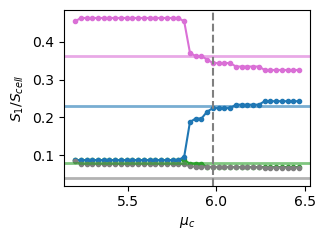

In [46]:
# Figure for the embryo # 7 
i = 7

plt.figure(figsize=(3.4,2.5))

plt.plot(cv_allembryos[i], S1A_allembryos[i], '.-', color='orchid')
plt.plot(cv_allembryos[i], S1B_allembryos[i], '.-', color='tab:green')
plt.plot(cv_allembryos[i], S1C_allembryos[i], '.-', color='tab:blue')
plt.plot(cv_allembryos[i], S1D_allembryos[i], '.-', color='tab:grey')

plt.axhline(y= S1_cellA_exp[index_expdata[i]]/Stot_cellA_exp[index_expdata[i]], color='orchid', alpha=0.6, linewidth=2)
plt.axhline(y= S1_cellB_exp[index_expdata[i]]/Stot_cellB_exp[index_expdata[i]], color='tab:green', alpha=0.6, linewidth=2)
plt.axhline(y= S1_cellC_exp[index_expdata[i]]/Stot_cellC_exp[index_expdata[i]], color='tab:blue', alpha=0.6, linewidth=2)
plt.axhline(y= S1_cellD_exp[index_expdata[i]]/Stot_cellD_exp[index_expdata[i]], color='tab:grey', alpha=0.6, linewidth=2)

plt.axvline(x= c_optimal[i], linestyle='--', color='grey')
plt.xlabel('$\\mu_c$')
plt.ylabel('$S_1/S_{cell}$')

plt.tight_layout()
plt.show()

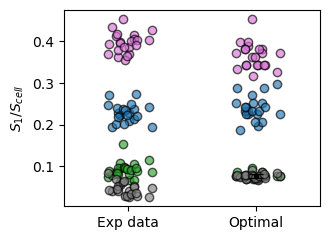

In [48]:
np.random.seed(16)
x_exp = np.random.normal(1,0.1, 26)

# Select only the data used
x_exp = x_exp[index_expdata]
S1A_exp = S1_cellA_exp[index_expdata]
S1B_exp = S1_cellB_exp[index_expdata]
S1C_exp = S1_cellC_exp[index_expdata]
S1D_exp = S1_cellD_exp[index_expdata]
StotA_exp = Stot_cellA_exp[index_expdata]
StotB_exp = Stot_cellB_exp[index_expdata]
StotC_exp = Stot_cellC_exp[index_expdata]
StotD_exp = Stot_cellD_exp[index_expdata]

# Figure
plt.figure(figsize=(3.4,2.5))
plt.scatter(x_exp, S1A_exp/StotA_exp, alpha=0.65, edgecolor='k', color='orchid', marker='o')
plt.scatter(x_exp, S1B_exp/StotB_exp, alpha=0.65, edgecolor='k', color='tab:green', marker='o')
plt.scatter(x_exp, S1C_exp/StotC_exp, alpha=0.65, edgecolor='k', color='tab:blue', marker='o')
plt.scatter(x_exp, S1D_exp/StotD_exp, alpha=0.65, edgecolor='k', color='grey', marker='o')

plt.scatter(x_exp +1, S1A_optimal, alpha=0.65, edgecolor='k', color='orchid')
plt.scatter(x_exp +1, S1B_optimal, alpha=0.65, edgecolor='k', color='tab:green')
plt.scatter(x_exp +1, S1C_optimal, alpha=0.65, edgecolor='k', color='tab:blue')
plt.scatter(x_exp +1, S1D_optimal, alpha=0.65, edgecolor='k', color='grey')

plt.errorbar(2,np.mean(S1D_optimal) ,np.std(S1D_optimal), marker='o',markersize=3,color='black', capsize=5,mfc='black', mec='black', ls='none',zorder=2)

plt.ylabel('$S_1/S_{cell}$', fontsize=10)
plt.xticks([1, 2], ['Exp data', 'Optimal'], fontsize=10)
plt.xlim([0.5,2.5])

plt.tight_layout()
plt.show()
